# **Camera Calibration**

This notebook explores using OpenCV to correct camera distortion using checkerboard calibration.

## **Imports**

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
%matplotlib inline

## **Motivation**

Cameras naturally produce distortion and abberations causing the ouput video/image geometries to not accurately represent the real-world geometries. When working with computer vision, specifically with measurements, it is important to reduce the distortion within the data to accurately represent geometries. We want to ensure that what we measure through the computer vision system is the same as what we measure in real life.

There are numerous ways to calibrate cameras. Complex problems that require a high degree of precision need to ensure that the vision system is also calibrated to a high degree of precision. Contrarily, a simple problem do not need a high degree of precision meaning that simpler calibrations methods are sufficient. In our case, our problem of lane detection does not require a high degree of precision so we are able to get away with simpler calibration methods.

Fortunately, `OpenCV` has an easy-to-use implementation of basic camera calibration known as [checkerboard calibration](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html). The OpenCV documentation explains the methodology pretty well with examples, but in essence the algorithm corrects radial and tangential distortion by finding the coordinates of the cornerers of a well-defined pattern (checkerboard) and compares it to the known real-world coordinated to solve for distortion coefficients. Let's first take a look at the images we will use for calibraiton.

## **Images for Calibration**

The calibration images contain pictures of a sheet of paper with an image of a chessboard taken from different angles and distances. Varying the perspective of the subject helps us to generalize the claibration to account for varying perspectives of the test camera. Here are the first four calibration images:

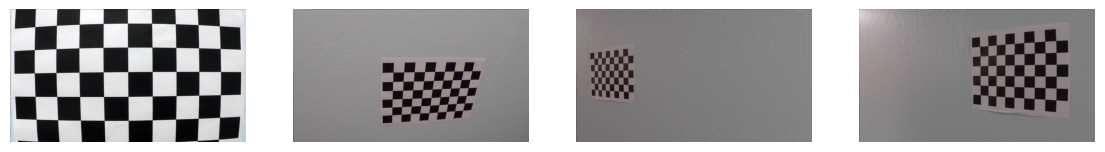

In [2]:
folder = 'camera_cal/'
images = []

# Load in all calibration images
for file in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, file))
    if img is not None:
        images.append(img)

# Plot first four images
_, axs = plt.subplots(1, 4, figsize = (14,12))
axs = axs.flatten()
for img, ax in zip(images[:4], axs):
    ax.imshow(img)
    ax.axis('off')
plt.show()

Pay close attention to the first image, we can see that the lines we know to be straight on the checkerboard appear to be curved in the image. This is a clear example of how cameras and lenses distort subjects within pictures. This head-on picture is not enough to accurately calibrate the camera, the next three images show the checkerboard at different angles and distances from the camera to increase generalization of the calibration. Now that we've seen the images, let's now implement the algorithm.

## **Implementation**

> Note: The code you are about to see is similar to what you can find in the documentation with a few tweaks here and there.

### Define "Real-Life" Corner Coordinates

In [3]:
board_size = (9, 6)             # Number of inner corners (x,y)
objpoints = []                  # 3D points in actual space
imgpoints = []                  # 2D points in image plane

# Create an array of zeros, where each row represents the 3D coordinate of a single corner point.
objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)

# Replace the first two columns of each row with x and y coordinates of the squares and the third column (z) with zero.
# These are our "real-life" coordinates of the checkerboard corners
objp[:, :2] = np.mgrid[:board_size[0], :board_size[1]].T.reshape(-1,2)

### Define "Distorted" Corner Coordinates

In [4]:
# Implement OpenCV's corner detection algorithm
# This finds the "distorted" coordinates of the checkerboard corners
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, board_size, None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

img_shape = gray.shape[::-1]

### Solve for Distortion Coefficients

In [5]:
# Implement OpenCV's distoriton coefficient solver
# We only care about the camera matrix (mtx) and distortion coefficients (dist) for this application
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)

### Remove Distortion

The best example to look at to see the result of this calibration method is to look a the head-on shot of the checkerboard. Let's compare the original image to the undistorted image.

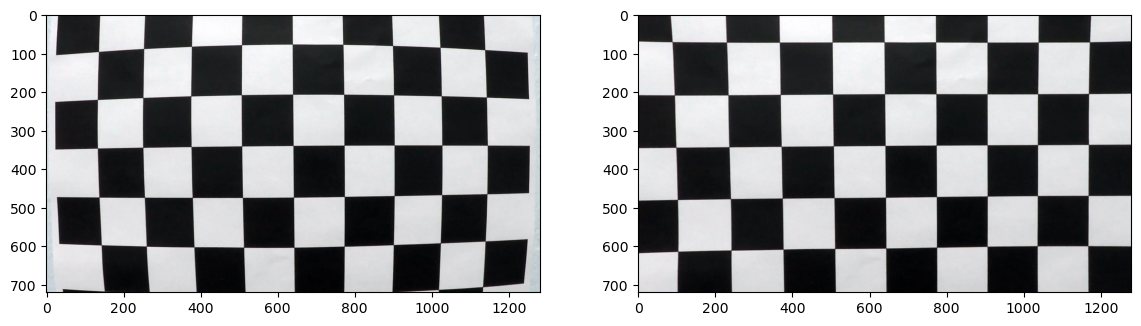

In [9]:
orig_img = images[0]
cal_img = cv2.undistort(orig_img, mtx, dist, None, mtx)

_, axs = plt.subplots(1, 2, figsize = (14,12))
axs[0].imshow(orig_img, cmap='gray')
axs[1].imshow(cal_img)
plt.show()

That's great! We can clearly see that distorted lines in the original image have been straighted in the undistorted image. Let's also take a look at one of our test image as well.

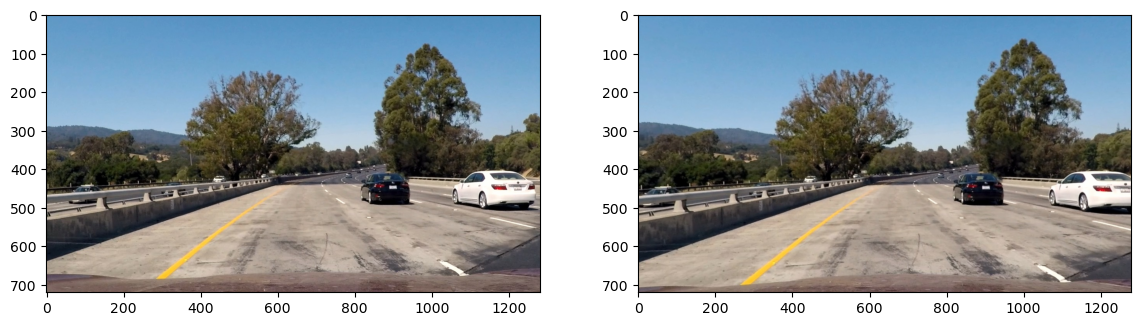

In [10]:
# Read in image
img_path = 'test_images/test1.jpg'
test_img = cv2.imread(img_path)

# Apply distortion removal
test_img_cal = cv2.undistort(test_img, mtx, dist, None, mtx)

# Convert to RGB
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_cal = cv2.cvtColor(test_img_cal, cv2.COLOR_BGR2RGB)

_, axs = plt.subplots(1, 2, figsize = (14,12))
axs[0].imshow(test_img)
axs[1].imshow(test_img_cal)
plt.show()

The test image contains a lot more details compared to the checkerboard image making it harder to notice the distortion removal. If you look closely, the image appears to have been cropped. We cannot see the right taillight of the white vehicle after removing the distortion. This is one of the consequenes of this algorithm, since the image is essentially being _flattened_, we will lose some information along the image borders. However for our application this isn't important, all we want is to make sure the lane lines in the image are a good representation of the lines in real life. The next step after `Camera Calibration` is `Perspective Transformation` in which the front-view is transformed into a birds-eye view of the road ahead.